# Homework 5: Photometric reverberation mapping

<span style="color:red">**Deadline:** </span> 08.05.2023.

# Task 1

**Goal:**

- Understand the photometric reverberation mapping method and its limitations. 
- Introduction to the tools for simulating AGN light curves and performing photoRM.

<span style="color:blue">**a)**</span> Familiarize yourself with photRM module (read the docs located in photRM.py). Using the `lc_two_bands` function from the `photRM` module, construct **three pairs** of continuum and emission line light curves of length 5000 days. This is a hypothetical scenario where we generate pairs of light curves as if they are observed in two broadband filters:

   - one covering only continuum emission (we will name it *x-band*)
   - second covering emission line and the underlying continuum (we will name it *y-band*)

Make sure that the light curve pairs are simulated for the artificial AGN objects at z = 0.1 having luminosity (log L): 43, 44, and 45, respectively. The emission line contribution to the total integrated flux should be 25% and the continuum contribution 75% in all cases. Plot the first 1000 days of the light curves and compare the properties (printed when you run `lc_two_bands`) of these three simulated AGN objects. How would you explain the correlation between AGN luminosity and broad line region dimensions (i.e. time-lag)? Cut the light curve length to 1000 points and save them for later use.

<span style="color:blue">**b)**</span> Using the photometric reverberation mapping method and the `pyzdcf` module, estimate the time-lag (broad line region radius) for these three light curve pairs. You can use the default values for keyword arguments in the function. How do the time-lag estimates compare to the values reported by `lc_two_bands`? You can estimate the time-lag using the `photRM.peak_finder` or (optionally) you can compile a Fortran code [PLIKE](https://www.weizmann.ac.il/particle/tal/research-activities/software) to obtain more accurate results and errors. Similarly display the results as in Astro Data Lab notebook.

>To install pyzdcf:
>
>   `pip install pyzdcf`
>    
>or you can run this notebook in Astro Data Lab where `pyzdcf` is already installed.

> To run PLIKE:
>
> - download the source code [here](https://webhome.weizmann.ac.il/home/tal/zdcf/plike_v4.0.f90)
> - if you don't have a fortran compiler, I suggest you install `gfortran` on your system
> - navigate to the folder containing the downloaded file
> - from there, run the following commands in the terminal:  
> `gfortran -o plike source_code_filename`  
> `./plike`

<span style="color:blue">**c)**</span> Now, to reflect a real-world scenario, let's make one of these three pairs of simulated light curves gappier (e.g., the one with log(L) = 44). Alter the light curves so they have the following cadences:

- one observation every 5 days
- one months of observations every day, then one month pause. Repeat the pattern.
- three month of observations every day, followed by six months of observations with a frequency of once per month and then a gap of three months. Repeat the pattern.

Estimate the time-lag from these three pairs of light curves. Write your conclusions regarding the accuracy of time-lag retrieval for different observing strategies you implemented. The light curves should not be longer than 1000 days.

In [147]:
# Standard lib

import os
import sys
import warnings
import random

# 3rd party libs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib.ticker as plticker
#from antares_client.search import search

%matplotlib inline

In [133]:
# Custom libs

path = '/home/jail/dlusers/ridhamm/notebooks_20230428_113458/05_Contrib/TimeDomain/PhotoReverberationMappingAGN/'
sys.path.append(path)

import photRM
from pyzdcf import pyzdcf

<span style="color:blue">**a) Generating light curves**</span> 

The LSST z filter covers only emission while LSST i covers H$_{\alpha}$ emission and the underlying continuum for an AGN at 0.1 z.

In [134]:
# Generating light curves for log(L) = 43

x_band1, y_band1, line_response1 = photRM.lc_two_bands(T=5000, 
                                             z=0.1,
                                             lum=43, 
                                             wl=0.25, 
                                             wc=0.75)

Properties of the simulated AGN object:
---------------------------------------
log(L) = 43.00
MBH = 3.14e+06 M_sun
tau_DRW = 17.31 days
sigma_DRW = 0.05 mag^2/day
Time-lag = 9.86 days


In [135]:
# Generating light curves for log(L) = 44

x_band2, y_band2, line_response2 = photRM.lc_two_bands(T=5000, 
                                             z=0.1,
                                             lum=44, 
                                             wl=0.25, 
                                             wc=0.75)

Properties of the simulated AGN object:
---------------------------------------
log(L) = 44.00
MBH = 1.46e+07 M_sun
tau_DRW = 31.98 days
sigma_DRW = 0.03 mag^2/day
Time-lag = 33.65 days


In [49]:
# Generating light curves for log(L) = 45

x_band3, y_band3, line_response3 = photRM.lc_two_bands(T=5000, 
                                             z=0.1,
                                             lum=45, 
                                             wl=0.25, 
                                             wc=0.75)

Properties of the simulated AGN object:
---------------------------------------
log(L) = 45.00
MBH = 6.76e+07 M_sun
tau_DRW = 59.10 days
sigma_DRW = 0.01 mag^2/day
Time-lag = 114.82 days


***Note:** The time-lag increases with bolometric luminosity. This means the BLR region is bigger when the AGN is brighter. This could be explained as a result of more material being accreted to the central black hole.*

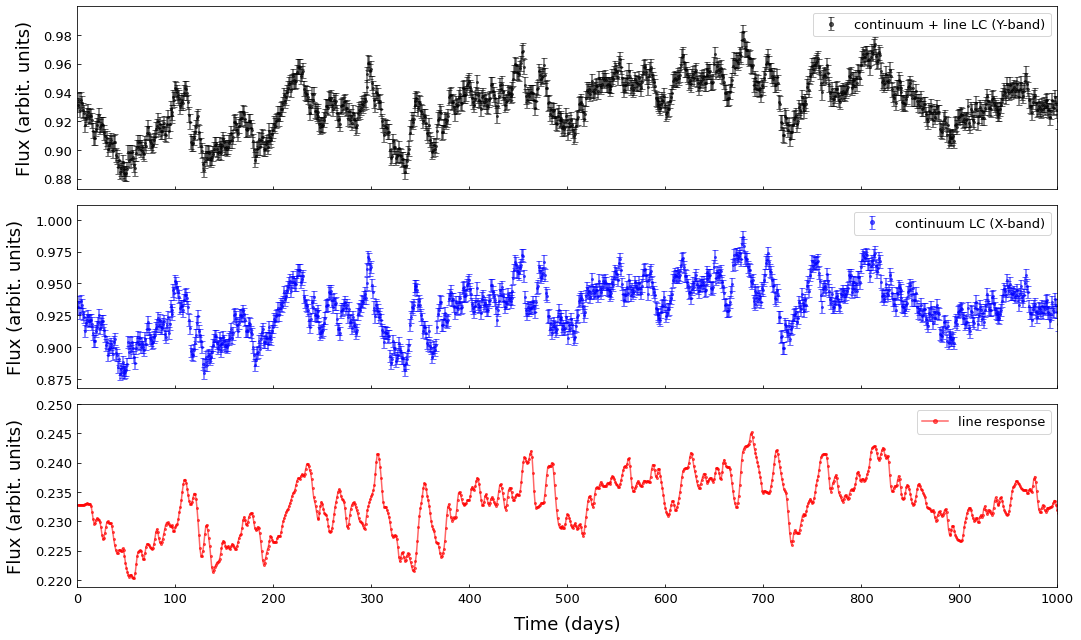

In [164]:
# Plot the light curves   

fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(15,9),tight_layout=True)
ax1.errorbar(y_band1['t'],y_band1['flux'],yerr=y_band1['err'],fmt='ko',markersize=2,alpha=0.6,capsize=3,label='continuum + line LC (Y-band)')
ax2.errorbar(x_band1['t'],x_band1['flux'],yerr=x_band1['err'],fmt='bo',markersize=2,alpha=0.6,capsize=3,label='continuum LC (X-band)')
ax3.plot(line_response1['t'], line_response1['flux'],'ro-', markersize=2,alpha=0.6, label='line response')

loc = plticker.MultipleLocator(100) # this locator puts ticks at regular intervals

for ax in [ax1,ax2,ax3]:
    ax.legend(fontsize=13,markerscale=2)
    ax.set_ylabel('Flux (arbit. units)',fontsize=18,labelpad=10)
    ax.tick_params(direction='in',pad=5,labelsize=13)
    ax.set_xlim(0,1000)
    ax.xaxis.set_major_locator(loc)

ax3.set_xlabel('Time (days)',fontsize=18,labelpad=10)
plt.show()

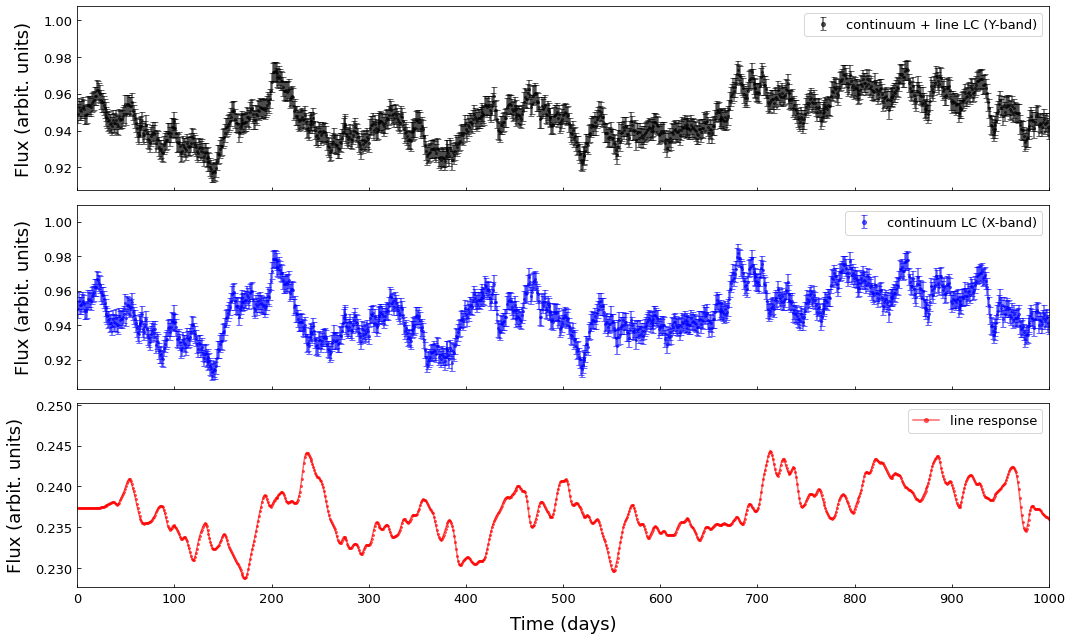

In [165]:
# Plot the light curves   

fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(15,9),tight_layout=True)
ax1.errorbar(y_band2['t'],y_band2['flux'],yerr=y_band2['err'],fmt='ko',markersize=2,alpha=0.6,capsize=3,label='continuum + line LC (Y-band)')
ax2.errorbar(x_band2['t'],x_band2['flux'],yerr=x_band2['err'],fmt='bo',markersize=2,alpha=0.6,capsize=3,label='continuum LC (X-band)')
ax3.plot(line_response2['t'], line_response2['flux'],'ro-', markersize=2,alpha=0.6, label='line response')

loc = plticker.MultipleLocator(100) # this locator puts ticks at regular intervals

for ax in [ax1,ax2,ax3]:
    ax.legend(fontsize=13,markerscale=2)
    ax.set_ylabel('Flux (arbit. units)',fontsize=18,labelpad=10)
    ax.tick_params(direction='in',pad=5,labelsize=13)
    ax.set_xlim(0,1000)
    ax.xaxis.set_major_locator(loc)

ax3.set_xlabel('Time (days)',fontsize=18,labelpad=10)
plt.show()

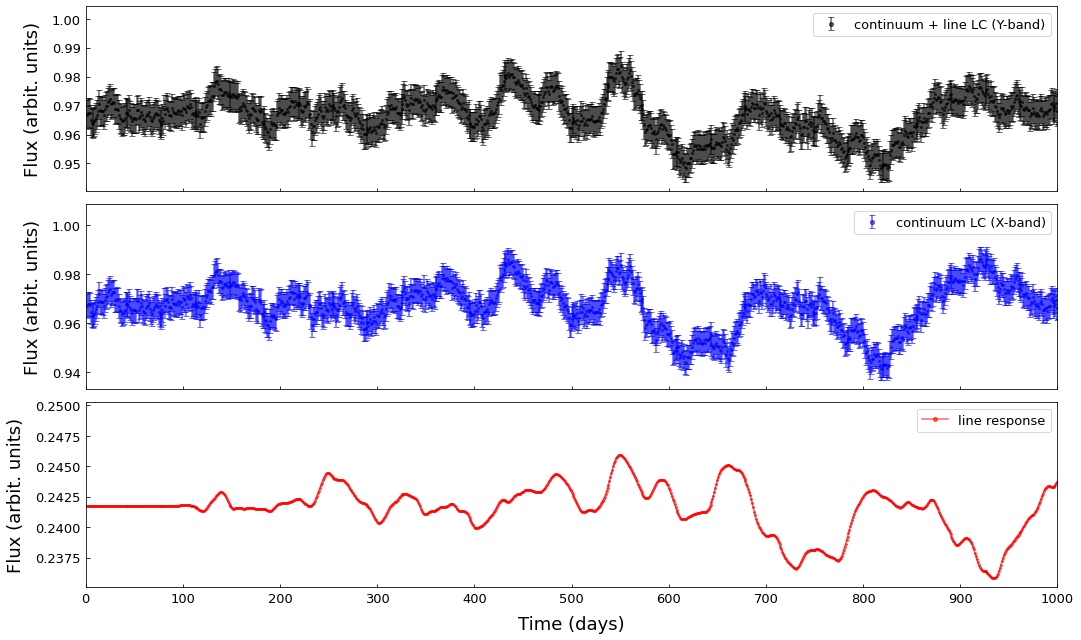

In [166]:
# Plot the light curves   

fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(15,9),tight_layout=True)
ax1.errorbar(y_band3['t'],y_band3['flux'],yerr=y_band3['err'],fmt='ko',markersize=2,alpha=0.6,capsize=3,label='continuum + line LC (Y-band)')
ax2.errorbar(x_band3['t'],x_band3['flux'],yerr=x_band3['err'],fmt='bo',markersize=2,alpha=0.6,capsize=3,label='continuum LC (X-band)')
ax3.plot(line_response3['t'], line_response3['flux'],'ro-', markersize=2,alpha=0.6, label='line response')

loc = plticker.MultipleLocator(100) # this locator puts ticks at regular intervals

for ax in [ax1,ax2,ax3]:
    ax.legend(fontsize=13,markerscale=2)
    ax.set_ylabel('Flux (arbit. units)',fontsize=18,labelpad=10)
    ax.tick_params(direction='in',pad=5,labelsize=13)
    ax.set_xlim(0,1000)
    ax.xaxis.set_major_locator(loc)

ax3.set_xlabel('Time (days)',fontsize=18,labelpad=10)
plt.show()

In [52]:
# Save the data

dir_path = path+'hw5/sim_data/'

cut = 1000
np.savetxt(dir_path+'x_band1.txt',np.c_[x_band1.t[:cut],x_band1.flux[:cut],x_band1.err[:cut]],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'y_band1.txt',np.c_[y_band1.t[:cut],y_band1.flux[:cut],y_band1.err[:cut]],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'x_band2.txt',np.c_[x_band2.t[:cut],x_band2.flux[:cut],x_band2.err[:cut]],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'y_band2.txt',np.c_[y_band2.t[:cut],y_band2.flux[:cut],y_band2.err[:cut]],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'x_band3.txt',np.c_[x_band3.t[:cut],x_band3.flux[:cut],x_band3.err[:cut]],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'y_band3.txt',np.c_[y_band3.t[:cut],y_band3.flux[:cut],y_band3.err[:cut]],fmt=['%.1f','%.7e','%.7e'])

<span style="color:blue">**b) Estimating time lag**</span> 

In [136]:
# Set input parameters for pyZDCF

input_dir = './sim_data/'
output_dir = './sim_results/'

lc_43_x = 'x_band1.txt'
lc_43_y = 'y_band1.txt'
lc_44_x = 'x_band2.txt'
lc_44_y = 'y_band2.txt'
lc_45_x = 'x_band3.txt'
lc_45_y = 'y_band3.txt'

In [137]:
# Time lag for log(L) = 43

# ACF calculation

params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc_43_x    # Name of the light curve file
             )

acf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')

# CCF calculation

params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc_43_x,   # Name of the first light curve file
              lc2_name          =  lc_43_y    # Name of the second light curve file
             )

ccf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')

# Interpolating

acf = photRM.interp(ccf,acf)
final_ccf = photRM.delta_ccf(acf, ccf)

# Estimating time lag

tau, peaks_x, peaks_y = photRM.peak_finder(final_ccf.dcf.values,final_ccf.tau.values,(0,100))

err_low = final_ccf.loc[final_ccf.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf.loc[final_ccf.tau == tau, '+sig(tau)'].values[0]


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

990 bins actually used, 45.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

992 bins actually used, 500032 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.

Peak candidates (x-axis vals):  [ 9. 43. 73.]
Max. peak:  9.0


In [138]:
# Time lag for log(L) = 44

# ACF calculation

params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc_44_x    # Name of the light curve file
             )

acf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')

# CCF calculation

params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc_44_x,   # Name of the first light curve file
              lc2_name          =  lc_44_y    # Name of the second light curve file
             )

ccf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')

# Interpolating

acf = photRM.interp(ccf,acf)
final_ccf = photRM.delta_ccf(acf, ccf)

# Estimating time lag

tau, peaks_x, peaks_y = photRM.peak_finder(final_ccf.dcf.values,final_ccf.tau.values,(0,100))

err_low = final_ccf.loc[final_ccf.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf.loc[final_ccf.tau == tau, '+sig(tau)'].values[0]


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

990 bins actually used, 45.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

992 bins actually used, 500032 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.

Peak candidates (x-axis vals):  [33. 71.]
Max. peak:  33.0


In [139]:
# Time lag for log(L) = 45

# ACF calculation

params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc_45_x    # Name of the light curve file
             )

acf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')

# CCF calculation

params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc_45_x,   # Name of the first light curve file
              lc2_name          =  lc_45_y    # Name of the second light curve file
             )

ccf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')

# Interpolating

acf = photRM.interp(ccf,acf)
final_ccf = photRM.delta_ccf(acf, ccf)

# Estimating time lag

tau, peaks_x, peaks_y = photRM.peak_finder(final_ccf.dcf.values,final_ccf.tau.values,(0,100))

err_low = final_ccf.loc[final_ccf.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf.loc[final_ccf.tau == tau, '+sig(tau)'].values[0]


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

990 bins actually used, 45.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

992 bins actually used, 500032 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.

Peak candidates (x-axis vals):  [3. 7.]
Max. peak:  7.0


<span style="color:blue">**c) Simulating LCs to represent real world scenario**</span> 

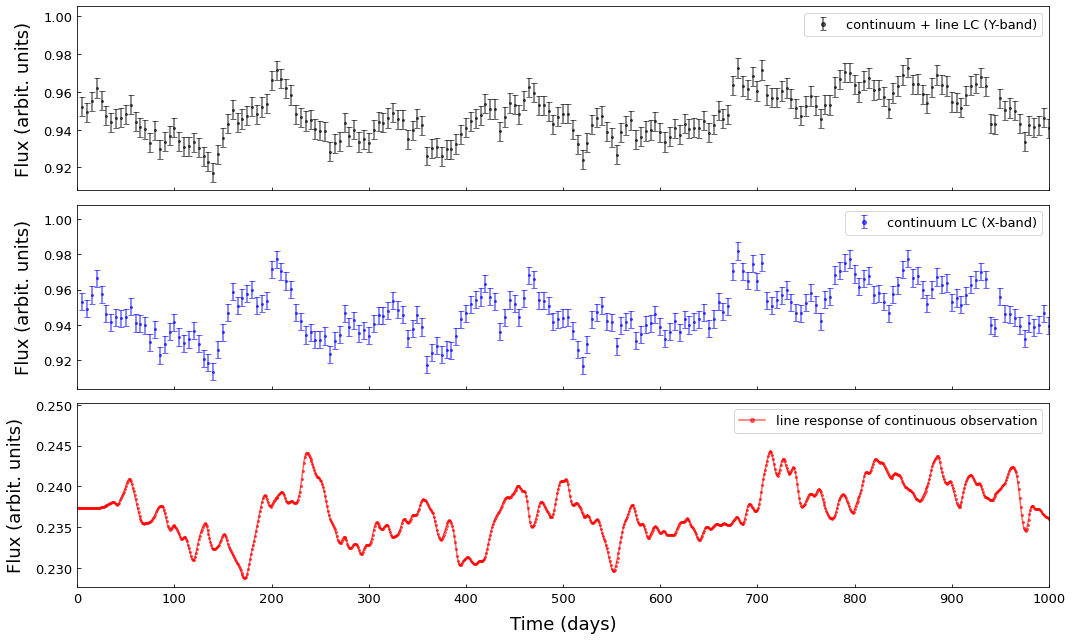

In [167]:
# Creating a LC with one observation every 5 days from the simulated LC for log(L)=44

warnings.filterwarnings('ignore')

x_band4 = pd.DataFrame()
y_band4 = pd.DataFrame()

for i in x_band2.index:
    if x_band2.loc[i, 't']%5 == 0:
        x_band4 = x_band4.append(x_band2.loc[i])
        y_band4 = y_band4.append(y_band2.loc[i])
        
# Plot the light curve   

fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(15,9),tight_layout=True)
ax1.errorbar(y_band4['t'],y_band4['flux'],yerr=y_band4['err'],fmt='ko',markersize=2,alpha=0.6,capsize=3,label='continuum + line LC (Y-band)')
ax2.errorbar(x_band4['t'],x_band4['flux'],yerr=x_band4['err'],fmt='bo',markersize=2,alpha=0.6,capsize=3,label='continuum LC (X-band)')
ax3.plot(line_response2['t'], line_response2['flux'],'ro-', markersize=2,alpha=0.6, label='line response of continuous observation')

loc = plticker.MultipleLocator(100) # this locator puts ticks at regular intervals

for ax in [ax1,ax2,ax3]:
    ax.legend(fontsize=13,markerscale=2)
    ax.set_ylabel('Flux (arbit. units)',fontsize=18,labelpad=10)
    ax.tick_params(direction='in',pad=5,labelsize=13)
    ax.set_xlim(0,1000)
    ax.xaxis.set_major_locator(loc)

ax3.set_xlabel('Time (days)',fontsize=18,labelpad=10)
plt.show()

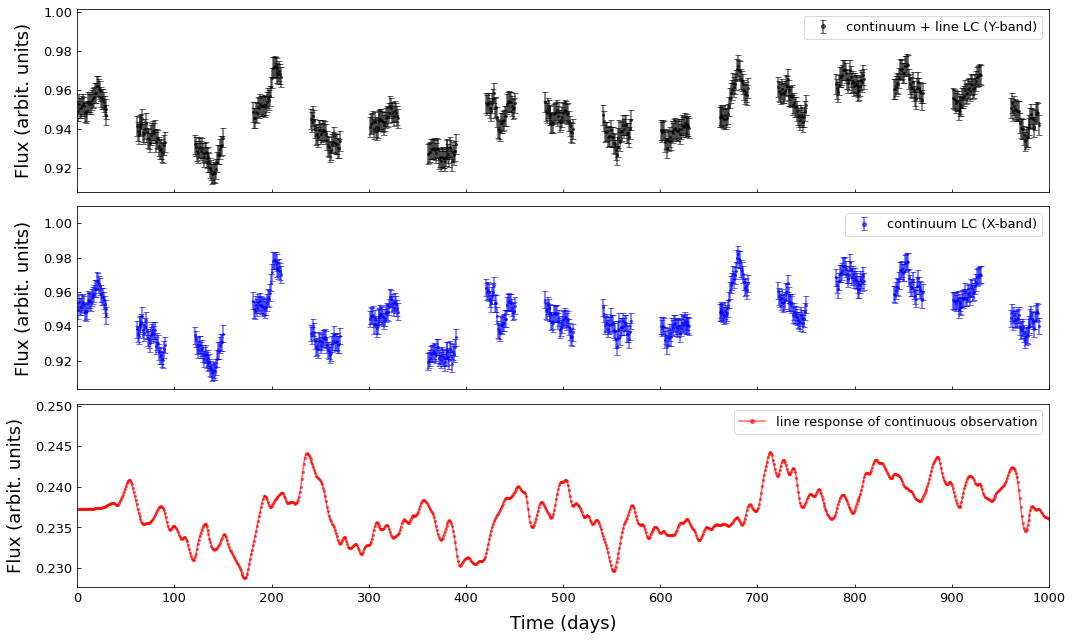

In [168]:
# Creating a LC with observation during odd months from the simulated LC for log(L)=44

warnings.filterwarnings('ignore')

num_months = round(5000/30)
t_obs = []

for i in range(0, num_months):
    if i%2 == 0:
        t_obs += [t+(i*30) for t in range(1, 31)]

x_band5 = pd.DataFrame()
y_band5 = pd.DataFrame()

for i in x_band2.index:
    if x_band2.loc[i, 't'] in t_obs:
        x_band5 = x_band5.append(x_band2.loc[i])
        y_band5 = y_band5.append(y_band2.loc[i])
        
# Plot the light curve   

fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(15,9),tight_layout=True)
ax1.errorbar(y_band5['t'],y_band5['flux'],yerr=y_band5['err'],fmt='ko',markersize=2,alpha=0.6,capsize=3,label='continuum + line LC (Y-band)')
ax2.errorbar(x_band5['t'],x_band5['flux'],yerr=x_band5['err'],fmt='bo',markersize=2,alpha=0.6,capsize=3,label='continuum LC (X-band)')
ax3.plot(line_response2['t'], line_response2['flux'],'ro-', markersize=2,alpha=0.6, label='line response of continuous observation')

loc = plticker.MultipleLocator(100) # this locator puts ticks at regular intervals

for ax in [ax1,ax2,ax3]:
    ax.legend(fontsize=13,markerscale=2)
    ax.set_ylabel('Flux (arbit. units)',fontsize=18,labelpad=10)
    ax.tick_params(direction='in',pad=5,labelsize=13)
    ax.set_xlim(0,1000)
    ax.xaxis.set_major_locator(loc)

ax3.set_xlabel('Time (days)',fontsize=18,labelpad=10)
plt.show()
    

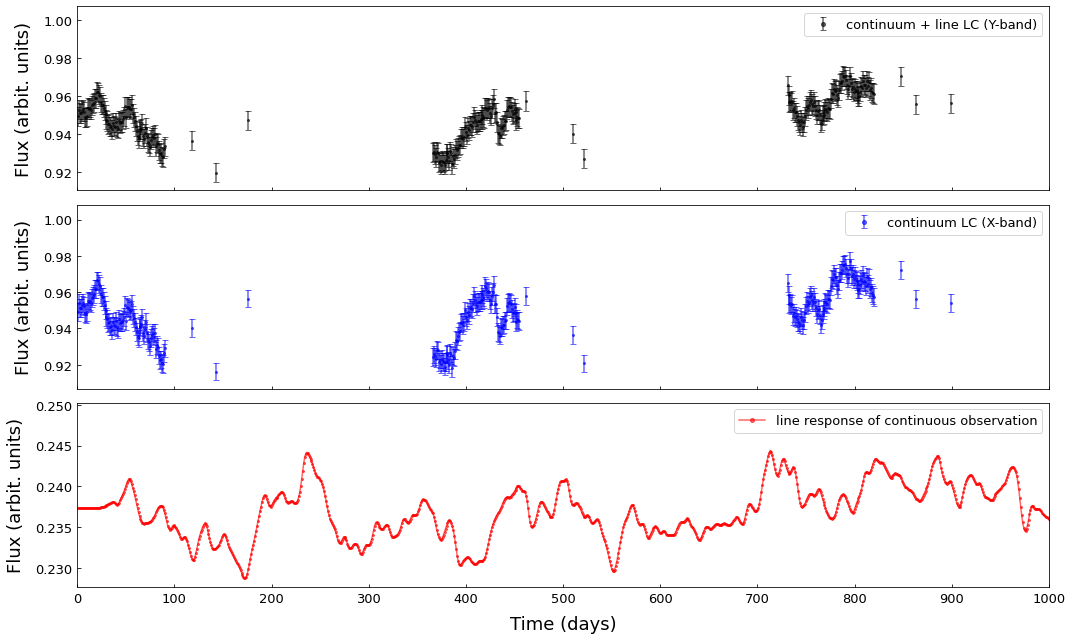

In [169]:
# Creating a LC with the following pattern from the simulated LC for log(L)=44:
## three month of observations every day, 
## followed by six months of observations with a frequency of once per month and
## a gap of three months

warnings.filterwarnings('ignore')

num_months = round(5000/30)
num_years = round(5000/365)
t_obs = []

for i in range(0, num_years):
    for j in range(0, 12):
        if j<=2:
            t_obs += [t+(j*30)+(i*365) for t in range(1, 31)]
        elif j>2 and j<=5:
            t = random.randint(1,31)
            t_obs += [t+(j*30)+(i*365)]
        elif j>5 and j<=11:
            continue

x_band6 = pd.DataFrame()
y_band6 = pd.DataFrame()

for i in x_band2.index:
    if x_band2.loc[i, 't'] in t_obs:
        x_band6 = x_band6.append(x_band2.loc[i])
        y_band6 = y_band6.append(y_band2.loc[i])
        
# Plot the light curve   

fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(15,9),tight_layout=True)
ax1.errorbar(y_band6['t'],y_band6['flux'],yerr=y_band6['err'],fmt='ko',markersize=2,alpha=0.6,capsize=3,label='continuum + line LC (Y-band)')
ax2.errorbar(x_band6['t'],x_band6['flux'],yerr=x_band6['err'],fmt='bo',markersize=2,alpha=0.6,capsize=3,label='continuum LC (X-band)')
ax3.plot(line_response2['t'], line_response2['flux'],'ro-', markersize=2,alpha=0.6, label='line response of continuous observation')

loc = plticker.MultipleLocator(100) # this locator puts ticks at regular intervals

for ax in [ax1,ax2,ax3]:
    ax.legend(fontsize=13,markerscale=2)
    ax.set_ylabel('Flux (arbit. units)',fontsize=18,labelpad=10)
    ax.tick_params(direction='in',pad=5,labelsize=13)
    ax.set_xlim(0,1000)
    ax.xaxis.set_major_locator(loc)

ax3.set_xlabel('Time (days)',fontsize=18,labelpad=10)
plt.show()

In [170]:
# Save the data

dir_path = path+'hw5/sim_data/'

cut = 1000
np.savetxt(dir_path+'x_band4.txt',np.c_[x_band4.t[:cut],x_band4.flux[:cut],x_band4.err[:cut]],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'y_band4.txt',np.c_[y_band4.t[:cut],y_band4.flux[:cut],y_band4.err[:cut]],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'x_band5.txt',np.c_[x_band5.t[:cut],x_band5.flux[:cut],x_band5.err[:cut]],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'y_band5.txt',np.c_[y_band5.t[:cut],y_band5.flux[:cut],y_band5.err[:cut]],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'x_band6.txt',np.c_[x_band6.t[:cut],x_band6.flux[:cut],x_band6.err[:cut]],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'y_band6.txt',np.c_[y_band6.t[:cut],y_band6.flux[:cut],y_band6.err[:cut]],fmt=['%.1f','%.7e','%.7e'])

In [171]:
# Set input parameters for pyZDCF

input_dir = './sim_data/'
output_dir = './sim_results/'

lc_44_5d_x = 'x_band4.txt'
lc_44_5d_y = 'y_band4.txt'
lc_44_om_x = 'x_band5.txt'
lc_44_om_y = 'y_band5.txt'
lc_44_br_x = 'x_band6.txt'
lc_44_br_y = 'y_band6.txt'

In [172]:
# Time lag for log(L) = 45

# ACF calculation

params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc_44_5d_x    # Name of the light curve file
             )

acf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')

# CCF calculation

params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc_44_5d_x,   # Name of the first light curve file
              lc2_name          =  lc_44_5d_y    # Name of the second light curve file
             )

ccf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')

# Interpolating

acf = photRM.interp(ccf,acf)
final_ccf = photRM.delta_ccf(acf, ccf)

# Estimating time lag

tau, peaks_x, peaks_y = photRM.peak_finder(final_ccf.dcf.values,final_ccf.tau.values,(0,100))

err_low = final_ccf.loc[final_ccf.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf.loc[final_ccf.tau == tau, '+sig(tau)'].values[0]


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

990 bins actually used, 45.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

992 bins actually used, 500032 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.

Peak candidates (x-axis vals):  [35.]
Max. peak:  35.0


In [175]:
# Time lag for log(L) = 45

# ACF calculation

params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc_44_om_x    # Name of the light curve file
             )

acf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')

# CCF calculation

params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc_44_om_x,   # Name of the first light curve file
              lc2_name          =  lc_44_om_y    # Name of the second light curve file
             )

ccf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')

# Interpolating

acf = photRM.interp(ccf,acf)
final_ccf = photRM.delta_ccf(acf, ccf)

# Estimating time lag

tau, peaks_x, peaks_y = photRM.peak_finder(final_ccf.dcf.values,final_ccf.tau.values,(0,100))

err_low = final_ccf.loc[final_ccf.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf.loc[final_ccf.tau == tau, '+sig(tau)'].values[0]


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

952 bins actually used, 249773.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

340 bins actually used, 894434 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.



ValueError: attempt to get argmax of an empty sequence

***Note:** No peak was found. Using PLIKE might give a peak estimate.*

In [174]:
# Time lag for log(L) = 45

# ACF calculation

params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc_44_br_x    # Name of the light curve file
             )

acf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')

# CCF calculation

params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc_44_br_x,   # Name of the first light curve file
              lc2_name          =  lc_44_br_y    # Name of the second light curve file
             )

ccf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')

# Interpolating

acf = photRM.interp(ccf,acf)
final_ccf = photRM.delta_ccf(acf, ccf)

# Estimating time lag

tau, peaks_x, peaks_y = photRM.peak_finder(final_ccf.dcf.values,final_ccf.tau.values,(0,100))

err_low = final_ccf.loc[final_ccf.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf.loc[final_ccf.tau == tau, '+sig(tau)'].values[0]


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

143 bins actually used, 487997.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

116 bins actually used, 985650 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.

Peak candidates (x-axis vals):  [44.27961165]
Max. peak:  44.279611650485435


# Task 2

**Goal:** Apply photometric reverberation mapping to real-world data.

Download photometric light curves of NGC 4395 from Edri et al. (2012). Choose one filter which covers the continuum emission only and the other one that covers the H$\alpha$ emission line and the underlying continuum. Using the utility functions provided, process the data so that time is expressed in hours and line intensity and its error are expressed as normalized flux. Plot the light curves. You will see that they are divided into segments because we have a pause in observations during the daylight. Choose the first segment and estimate the time lag using this data. Compare your results to Edri et al. (2012) and discuss the pros and cons of photometric reverberation mapping compared to spectroscopic reverberation mapping.

In [176]:
# Read the light curves using pd.read_csv()

lc_r = pd.read_csv('obs_data/lc_r.txt', header=0, sep="\s+", skipinitialspace=True, usecols=[0,1,2]) # H_beta + continuum
lc_i = pd.read_csv('obs_data/lc_i.txt', header=0, sep="\s+", skipinitialspace=True, usecols=[0,1,2]) # continuum

In [178]:
# Light curve processing utility function

from lc_proc import lc_proc

lcs = [lc_r, lc_i]
filters = ['r', 'i'] # see lc_proc docs for accepted values for filters
new_lcs = lc_proc(lcs, filters)

In [182]:
new_lcs[0]

,MJD,mag,mag_err,time_hours,flux,flux_err,norm_flux,norm_flux_err
0,2.455616e+06,16.272,0.027,0.00000,2577.507870,69.592712,0.367951,0.139859
1,2.455616e+06,16.270,0.026,0.46464,2582.260191,67.138765,0.377501,0.134927
2,2.455616e+06,16.263,0.022,0.69696,2598.962421,57.177173,0.411067,0.114907
3,2.455616e+06,16.260,0.021,0.92928,2606.153550,54.729225,0.425519,0.109988
4,2.455616e+06,16.251,0.021,1.16160,2627.846541,55.184777,0.469115,0.110903
...,...,...,...,...,...,...,...,...
277,2.455627e+06,16.305,0.021,246.94248,2500.345362,52.507253,0.212879,0.105522
278,2.455627e+06,16.319,0.023,247.17528,2468.311690,56.771169,0.148502,0.114092
279,2.455627e+06,16.301,0.023,247.40808,2509.573964,57.720201,0.231426,0.115999
280,2.455627e+06,16.305,0.023,247.64064,2500.345362,57.507943,0.212879,0.115572


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


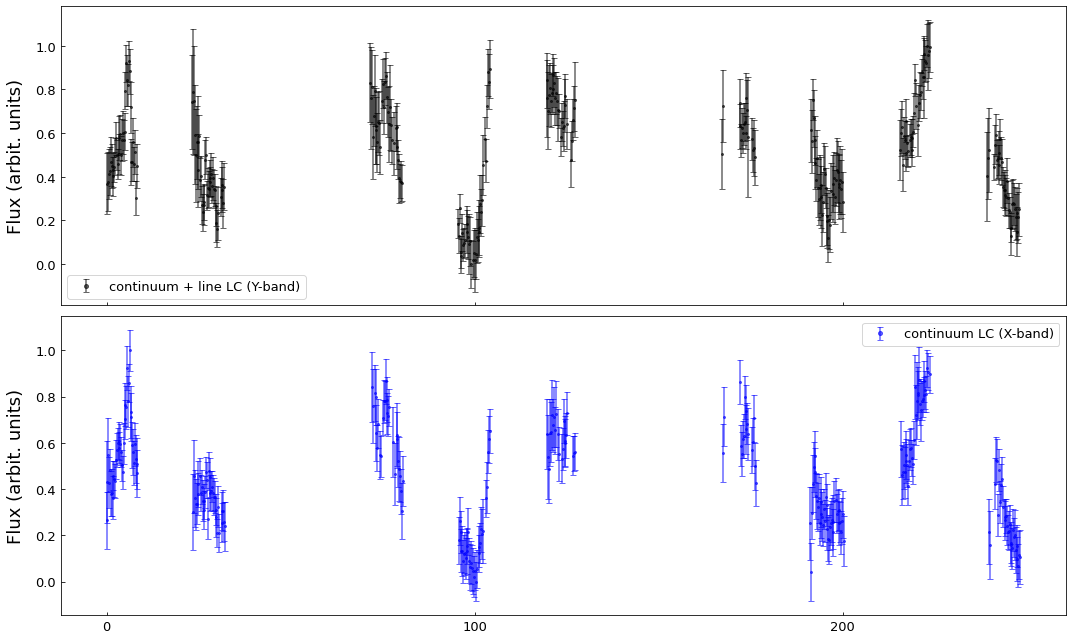

In [186]:
# Plot the light curve   

fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(15,9),tight_layout=True)
ax1.errorbar(new_lcs[0]['time_hours'],new_lcs[0]['norm_flux'],yerr=new_lcs[0]['norm_flux_err'],fmt='ko',markersize=2,alpha=0.6,capsize=3,label='continuum + line LC (Y-band)')
ax2.errorbar(new_lcs[1]['time_hours'],new_lcs[1]['norm_flux'],yerr=new_lcs[1]['norm_flux_err'],fmt='bo',markersize=2,alpha=0.6,capsize=3,label='continuum LC (X-band)')

loc = plticker.MultipleLocator(100) # this locator puts ticks at regular intervals

for ax in [ax1,ax2,ax3]:
    ax.legend(fontsize=13,markerscale=2)
    ax.set_ylabel('Flux (arbit. units)',fontsize=18,labelpad=10)
    ax.tick_params(direction='in',pad=5,labelsize=13)
    ax.xaxis.set_major_locator(loc)

ax3.set_xlabel('Time (days)',fontsize=18,labelpad=10)
plt.show()

In [201]:
# Taking first segment 

lc_r_proc = new_lcs[0]
lc_i_proc = new_lcs[1]
lc_r_proc_seg1 = lc_r_proc[lc_r_proc['time_hours']<60]
lc_i_proc_seg1 = lc_i_proc[lc_i_proc['time_hours']<60]

# Save the data

dir_path = path+'hw5/obs_data/'

np.savetxt(dir_path+'x_band7.txt', np.c_[lc_i_proc_seg1['time_hours'],lc_i_proc_seg1['norm_flux'],lc_i_proc_seg1['norm_flux_err']],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'y_band7.txt', np.c_[lc_r_proc_seg1['time_hours'],lc_r_proc_seg1['norm_flux'],lc_r_proc_seg1['norm_flux_err']],fmt=['%.1f','%.7e','%.7e'])

In [202]:
# Time lag for Edri et al 2012 data

# Set input parameters for pyZDCF

input_dir = './obs_data/'
output_dir = './obs_results/'

lc_i_proc_seg1 = 'x_band7.txt'
lc_r_proc_seg1 = 'y_band7.txt'

# ACF calculation

params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc_i_proc_seg1    # Name of the light curve file
             )

acf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')

# CCF calculation

params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc_i_proc_seg1,   # Name of the first light curve file
              lc2_name          =  lc_r_proc_seg1    # Name of the second light curve file
             )

ccf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')

# Interpolating

acf = photRM.interp(ccf,acf)
final_ccf = photRM.delta_ccf(acf, ccf)

# Estimating time lag

tau, peaks_x, peaks_y = photRM.peak_finder(final_ccf.dcf.values,final_ccf.tau.values,(0,100))

err_low = final_ccf.loc[final_ccf.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf.loc[final_ccf.tau == tau, '+sig(tau)'].values[0]


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

98 bins actually used, 313.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

192 bins actually used, 730 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.

Peak candidates (x-axis vals):  [ 0.5         0.89999998  1.39482756  1.70000005  2.0923076   2.4000001
  2.7891304   3.48500001  4.          4.69999981  5.0999999   5.57826079
  5.98333335  6.72499994  7.89999979 20.10000038 20.5        20.79999924
 21.20000076 21.5        22.20000076 22.89999962 23.77

***Note:** The function returns the maximum peak. But there are other possible time lags defined above. By knowing uncertainties of the peak, we would be able to tell the best peak in the set of candidates.*

*Edri et al (2012) report a 3.6 +/- 0.8 hour time lag. We have candidates that are within one sigma of the reported value.*

**Photometric vs spectroscopic reverberation mapping (PRM vs SRM):**

SRM is more accurate than PRM, especially for AGNs, where the power of the source is concentrated in wavelength ranges narrower than typical filters. But at high redshifts, when we don't have enough resolution to perform SRM, we could choose PRM. 

Photometry allows us to record multiple sources at the same time with small telescopes. 

Photometry has a better SNR since all the photons received in the waveband is recorded by the CCD with less noise. In case of spectroscopy, the dispersion of light reduces photons received per "cell" of CCD leading to noise dominating the signal and to overcome this the exposure should be longer. 

Due to these reasons, PRM could prove to be a better choice for surveys like LSST. In case of individual or small sample studies, SRM is superior.

# References:

- Edri et al. (2012) https://ui.adsabs.harvard.edu/abs/2012ApJ...756...73E/abstract
- Jankov et al. (2022) https://ui.adsabs.harvard.edu/abs/2022AN....34310090J/abstract
- Kovacevic et al. (2021) https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5012K/abstract
- [Astro Data Lab](https://datalab.noirlab.edu/)
- [pyzdcf documentation](https://pyzdcf.readthedocs.io/en/latest/?badge=latest)
- [PLIKE download link](https://www.weizmann.ac.il/particle/tal/research-activities/software)